In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [2]:
# месячное скользящее окно
window = 13

# макс KPSS статистика (95% critical value)
KPSS_max = 0.463

# параметры стратегии - коммиссии, отпимальный вход и стоп-лосс
fee = 0.001
entry = 0.02
stop_loss = -0.05

# начинаем с кэша
signal = 0
current_return = 0
position0 = 0
position1 = 0

# обозначаем наш сэмпл
start = '2019-01-04'
end = '2021-08-07'

# торговая пара
tickers = ['IMMP','SYPR']
# индекс S&P500
market = '^GSPC'

# вводим массивы
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()

tickers_data = pd.DataFrame()
market_data = pd.DataFrame()
market_data['market'] = yf.download(market, start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
df6_test = pd.read_csv('df6_tot_test.csv', index_col = 'date')
for ticker in tickers:
    tickers_data[ticker] = df6_test[ticker]
tickers_data.index = tickers_data.index.astype('datetime64[ns]')
raw_data = pd.concat([tickers_data, market_data], axis=1)
print(np.where(raw_data.isna()))
raw_data

(array([], dtype=int64), array([], dtype=int64))


,IMMP,SYPR,market
2019-01-03,2.0500,0.9800,2447.889893
2019-01-04,2.1500,0.9700,2531.939941
2019-01-07,2.1500,0.9311,2549.689941
2019-01-08,2.1399,0.9800,2574.409912
2019-01-09,2.1800,0.9849,2584.959961
...,...,...,...
2021-08-02,3.4600,3.0700,4387.160156
2021-08-03,3.5800,3.0300,4423.149902
2021-08-04,3.5900,3.0400,4402.660156
2021-08-05,3.7400,3.0900,4429.100098


In [4]:
spread_stats = []
b_opts = []
# проводим по циклу наш сэмпл 
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    # обозначим наш подсэмпл
    data = raw_data[t-window:t]
    #stock 2 = (a=0) + b*stock 1 
    # стартовые параметры OLS
    reg = sm.OLS(np.array(data[tickers[1]]), np.array(data[tickers[0]]))
    res = reg.fit()
    b0 = res.params[0]
    
    # функция KPSS одно-параметрическая
    def KPSS(b):
        resid = np.array(data[tickers[1]] - (b*data[tickers[0]]))
        cum_resid = np.cumsum(resid)
        st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
        KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
        return KPSS
    # минимизируем KPSS функцию (максимизируем стационарность)
    res = spop.minimize(KPSS, b0, method='Nelder-Mead')
    KPSS_opt = res.fun
    # наши оптимальные параметры
    b_opt = float(res.x)
    if (len(b_opts) > window) and (abs(b_opt - np.mean(b_opts)) > 3*np.std(b_opts)):
        b_opt = b_opts[-1]
    #print('OLS_opt: ', np.round(b_opt, 2), np.round(a_opt, 2))
    # симуляция торгов
    # сначала проверим не сработал ли стоп-лосс
    spread = raw_data[tickers[1]][t] - (b_opt*raw_data[tickers[0]][t])
    returns = raw_data[tickers[1]][t]/(b_opt*raw_data[tickers[0]][t])-1
    if current_return < stop_loss:
        signal = 0
        #print('stop-loss triggered')
    # если мы уже в позиции, проверим произошел ли возврат к среднему, продолжаем держать, если нет.
    elif np.sign(spread) == old_signal:
        singal = old_signal
    else:
        # торгуем только если есть коинтеграция
        if KPSS_opt > KPSS_max:
            signal = 0
        # тогруем только если есть существенное отклонение от средней
        elif abs(returns) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (b_opt*raw_data[tickers[0]][t]))
    # считаем доходность стратегии
    position0 = signal
    position1 = -signal
    # считаем доходность
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - b_opt*fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    # заполняем массивы
    b_opts.append(b_opt)
    spread_stats.append(spread)
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)

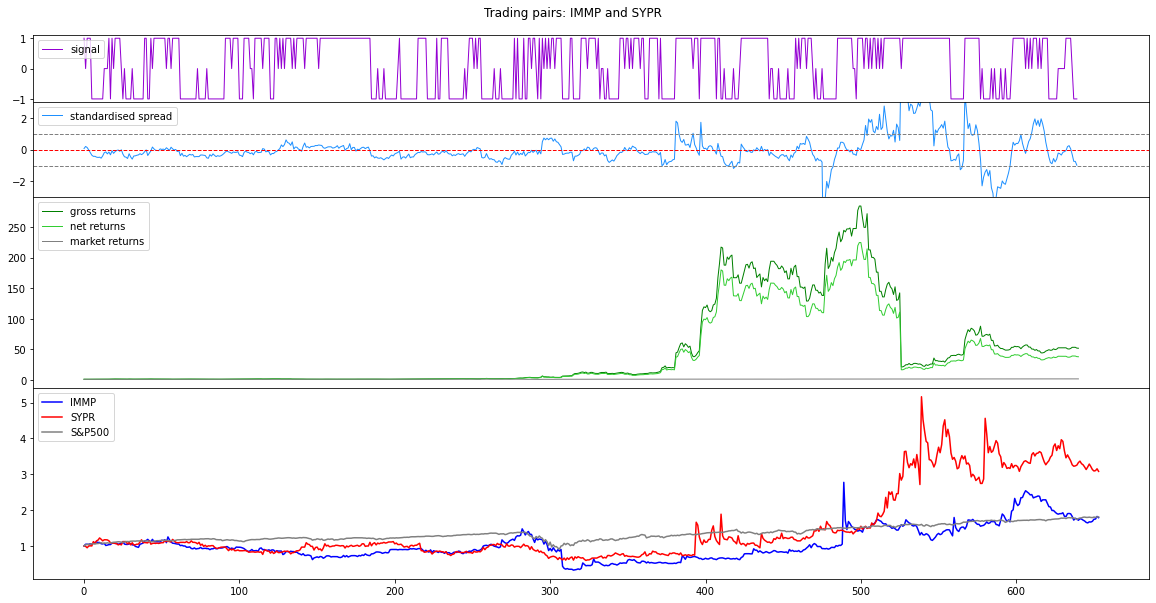

In [5]:
def zscore(series):
    return (series - np.mean(series)) / np.std(series)
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(4, hspace=0, height_ratios=[0.7, 1, 2, 2])
axs = gs.subplots(sharex=True)
fig.suptitle('Trading pairs: ' + str(tickers[0]) + ' and ' + str(tickers[1]), y=0.92)

axs[0].plot(signals, lw=1, label='signal', c='darkviolet')

axs[1].plot(zscore(spread_stats), lw=1, label='standardised spread', c='dodgerblue')
axs[1].axhline(y=1, xmin=0, xmax=1, linestyle='--', color='grey', lw=1)
axs[1].axhline(y=0, xmin=0, xmax=1, linestyle='--', color='r', lw=1)
axs[1].axhline(y=-1, xmin=0, xmax=1, linestyle='--', color='grey', lw=1)
axs[1].set_ylim((-3, 3))

axs[2].plot(np.append(1,np.cumprod(1+gross_returns)), lw=1, label='gross returns', c='green')
axs[2].plot(np.append(1,np.cumprod(1+net_returns)), lw=1, label='net returns', c='limegreen')
axs[2].plot(np.append(1,np.cumprod(1+market_returns)), lw=1, label='market returns', c='gray')


axs[3].plot(np.array(raw_data[tickers[0]]/raw_data[tickers[0]][0]), label=tickers[0], color='blue')
axs[3].plot(np.array(raw_data[tickers[1]]/raw_data[tickers[1]][0]), label=tickers[1], color='red')
axs[3].plot(np.array(raw_data['market']/raw_data['market'][0]), label='S&P500', color='gray')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')